In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import matplotlib.pyplot as plt
import matplotlib as mpl

def set_latex_plot_style():
    plt.rcParams.update({
        "text.usetex": True,                     # czcionka LaTeX
        "font.family": "serif",                  # domyślna czcionka LaTeX (Computer Modern)
        "figure.figsize": (6, 4),                # rozmiar w calach: ok. 15 x 10 cm
        "axes.titlesize": 12,
        "axes.labelsize": 11,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
        "legend.fontsize": 10,
        "legend.frameon": True,
        "legend.loc": 'best',
        "axes.grid": True,
        "grid.alpha": 0.3,
        "lines.linewidth": 1.5,
        "lines.markersize": 5,
        "savefig.bbox": "tight",
        "pdf.fonttype": 42,                      # poprawne fonty w PDF
        "ps.fonttype": 42
    })
set_latex_plot_style

def load_data(base_dir, sample_n=50):
    all_data = []
    tickers_seen = set()

    for root, _, files in os.walk(base_dir):
        np.random.shuffle(files)
        for file in files:
            if file.endswith('.csv'):
                path = os.path.join(root, file)
                try:
                    # ticker z nazwy pliku
                    ticker = os.path.splitext(file)[0]
                    if ticker in tickers_seen:
                        continue

                    # wczytanie danych zgodnie z nowym formatem
                    df = pd.read_csv(path, skiprows=2, header=None,
                                     names=["Date", "Close", "High", "Low", "Open", "Volume"],
                                     usecols=["Date", "Close"])
                    df["Date"] = pd.to_datetime(df["Date"], format="%Y-%m-%d", errors="coerce")
                    df = df.dropna(subset=["Date", "Close"])

                    if df.shape[0] > 100:
                        df["TICKER"] = ticker
                        all_data.append(df)
                        tickers_seen.add(ticker)

                        if len(tickers_seen) >= sample_n:
                            break
                except Exception:
                    continue
        if len(tickers_seen) >= sample_n:
            break

    if not all_data:
        raise Exception("Brak danych")

    return pd.concat(all_data, ignore_index=True)


def prepare_pivot(df, start_year=2020, end_year=2025, max_nan_percent=5.0):
    df = df[(df["Date"].dt.year >= start_year) & (df["Date"].dt.year <= end_year)]
    pivot = df.pivot(index="Date", columns="TICKER", values="Close").sort_index()
    pivot = pivot[pivot.index.weekday < 5]  # usuń weekendy
    nans = pivot.isna().sum() / len(pivot) * 100
    good_tickers = nans[nans <= max_nan_percent].index.tolist()
    pivot = pivot[good_tickers].fillna(method="ffill").fillna(method="bfill")
    return pivot




def markowitz_portfolio(mean_returns, cov_matrix, target_return=0.001):
    mean_returns = np.array(mean_returns)
    cov_matrix = np.array(cov_matrix)
    n = len(mean_returns)
    w = cp.Variable(n) #wektor wag aktywów
    objective = cp.Minimize(cp.quad_form(w, cp.psd_wrap(cov_matrix))) #cel 
    #ograniczenia
    constraints = [
        cp.sum(w) == 1,
        w >= 0,
        w <= 0.1,
        mean_returns @ w >= target_return
    ]
    prob = cp.Problem(objective, constraints) #problem
    prob.solve(solver=cp.OSQP) #rozwiązanie
    return w.value

def rolling_markowitz(pivoted_prices, window_days=60, fee_rate=0.001, rebalance_period=5, target_return=0.001):
    returns = pivoted_prices.pct_change().dropna()
    returns_test = returns[returns.index.year == 2025]
    dates = returns_test.index
    capital_value = 1.0
    costs = 0.0

    n_assets = pivoted_prices.shape[1]
    prev_weights = pd.Series(1.0 / n_assets, index=pivoted_prices.columns)

    capital_by_day = []
    weights_by_day = []

    for start in range(0, len(dates), rebalance_period):
        end = min(start + rebalance_period, len(dates))
        period_dates = dates[start:end]

        # aktualizacja wag zgodnie z rynkiem
        if start > 0:
            date_prev = dates[start - rebalance_period]
            date_curr = dates[start]
            prices_prev = pivoted_prices.loc[date_prev]
            prices_curr = pivoted_prices.loc[date_curr]
            rel_returns = prices_curr / prices_prev

            prev_weights = prev_weights * rel_returns
            prev_weights = prev_weights / prev_weights.sum()

        # nowa optymalizacja
        date_curr = dates[start]
        data = returns.loc[:date_curr]
        mean_returns = data.tail(window_days).mean()
        cov_matrix = data.tail(window_days).cov()
        new_weights = markowitz_portfolio(mean_returns, cov_matrix, target_return)

        diff = np.abs(new_weights - prev_weights.values)
        if np.any(diff > 0.005):
            cost = fee_rate * diff.sum() * capital_value
            costs += cost
            capital_value -= cost
            prev_weights = pd.Series(new_weights, index=pivoted_prices.columns)

        # dzienne aktualizacje kapitału
        for date in period_dates:
            r = returns_test.loc[date]
            capital_value *= (1 + np.dot(prev_weights, r))
            capital_by_day.append((date, capital_value))
            weights_by_day.append((date, prev_weights.copy()))

    capital_series = pd.Series(dict(capital_by_day))
    weights_df = pd.DataFrame({date: w for date, w in weights_by_day}).T
    return capital_series, weights_df, costs


def rolling_equal(pivoted_prices, rebalance_period=5, fee_rate=0.001):
    returns = pivoted_prices.pct_change().dropna()
    returns_test = returns[returns.index.year == 2025]
    dates = returns_test.index
    capital_timeline = []
    capital = 1.0

 
    weights = pd.Series(1.0 / pivoted_prices.shape[1], index=pivoted_prices.columns)

 
    start_date = dates[0]
    start_prices = pivoted_prices.loc[start_date]
    shares = (weights * capital) / start_prices

 
    for date in dates:
        prices_today = pivoted_prices.loc[date]
        portfolio_value = np.sum(shares * prices_today)
        capital_timeline.append((date, portfolio_value))

    capital_series = pd.Series(dict(capital_timeline))
    return capital_series, 0.0  # brak kosztów

def calculate_portfolio_stats(capital_series):
  
    # CAGR, Sharpe Ratio, Max Drawdown.
    
    returns = capital_series.pct_change().dropna()

    #sredni zwrot
    mean_return=returns.mean()* 252

    # CAGR
    start_value = capital_series.iloc[0]
    end_value = capital_series.iloc[-1]
    n_years = (capital_series.index[-1] - capital_series.index[0]).days / 365.25
    annualized_return = (end_value / start_value) ** (1 / n_years) - 1

    # volatility
    std_dev = returns.std()
    annualized_volatility = std_dev * np.sqrt(252)

    # Sharpe Ratio 
    sharpe_ratio = (returns.mean() * 252) / annualized_volatility

    # Max Drawdown
    cum_returns = (1 + returns).cumprod()
    peak = cum_returns.cummax()
    drawdown = (cum_returns - peak) / peak
    max_drawdown = drawdown.min()

    return {
        "Zwrot roczny (CAGR)": annualized_return,
        "sredni zwrot": mean_return,
        "Zmienność roczna": annualized_volatility,
        "Sharpe Ratio": sharpe_ratio,
        "Max Drawdown": max_drawdown
    }



In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl

def set_consistent_plot_style():
    mpl.rcParams.update({
        # Rozmiar wykresów (szerokość x wysokość w calach)
        "figure.figsize": (6, 4),

        # Czcionki i styl tekstu
        "font.family": "serif",
        "font.size": 13,
        "axes.titlesize": 18,
        "axes.labelsize": 13,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,

        # Linie i punkty
        "lines.linewidth": 1.8,
        "lines.markersize": 6,

        # Siatka
        "axes.grid": True,
        "grid.alpha": 0.3,

        # Legenda
        "legend.fontsize": 13,
        "legend.frameon": True,
        "legend.loc": "best",

        # Zapis do PDF/PNG
        "savefig.bbox": "tight",
        "savefig.dpi": 300,
        "pdf.fonttype": 42,  # poprawne fonty w PDF
        "ps.fonttype": 42
    })
set_consistent_plot_style()

C:\Users\Basia\AppData\Local\Temp\ipykernel_3964\3571490325.py:78: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  pivot = pivot[good_tickers].fillna(method="ffill").fillna(method="bfill")


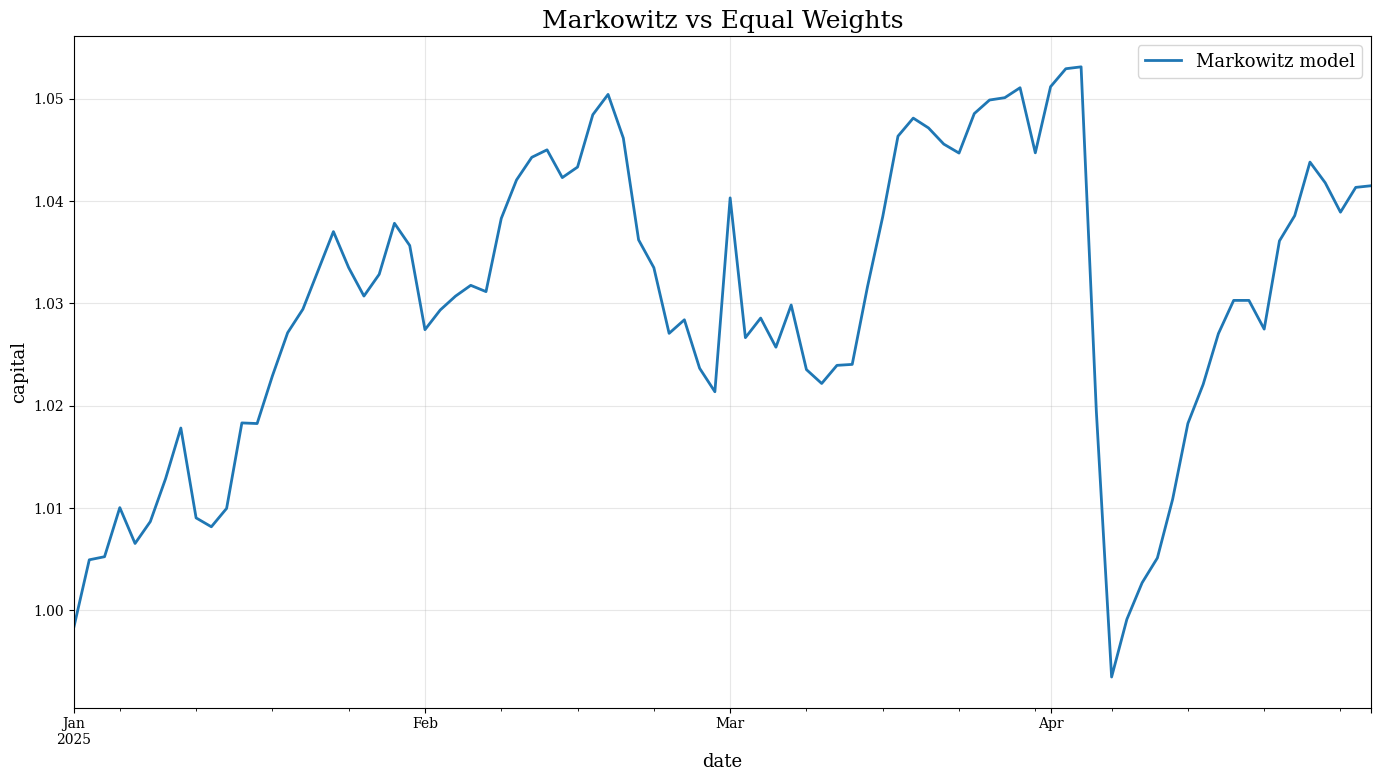

Statystyki Markowitz:
  Zwrot roczny (CAGR): 0.1384
  sredni zwrot: 0.1305
  Zmienność roczna: 0.1031
  Sharpe Ratio: 1.2661
  Max Drawdown: -0.0566
Statystyki Equal Weights:
  Zwrot roczny (CAGR): 0.1578
  sredni zwrot: 0.1506
  Zmienność roczna: 0.1350
  Sharpe Ratio: 1.1155
  Max Drawdown: -0.1031
koszty transakcyjne Markowitz: 0.0180
koszty transakcyjne Equal Weights: 0.0000


In [5]:

data_dir  = r"C:\Users\Basia\Do przejrzenia\am_sem2\mgr\kody\downloaded_data"
df_all = load_data(data_dir, sample_n=750)
pivoted = prepare_pivot(df_all)



#Zwrot roczny (CAGR)	sredni zwrot	Zmienność roczna	Sharpe Ratio	Max Drawdown	Okno (dni)	Target Return	Rebalans co (dni)	Koszt
#	0.614373	2.267380	0.390332	5.808847	-0.069009	60	0.0050	5	0.016243
#	0.289259	1.198232	0.277046	4.325025	-0.050308	30	0.0050	5	0.022610

# Markowitz
df_capital_mkv, wg, total_cost_mkv = rolling_markowitz(
    pivoted_prices=pivoted,
    window_days=60,
    fee_rate=0.001,
    rebalance_period=5,
    target_return=0.0025
)

# Equal Weights
df_capital_eq, total_cost_eq = rolling_equal(
    pivoted_prices=pivoted,
    rebalance_period=5,
    fee_rate=0.001
)

stats_mkv = calculate_portfolio_stats(df_capital_mkv)
stats_eq = calculate_portfolio_stats(df_capital_eq)


plt.figure(figsize=(14, 8))
df_capital_mkv.plot(label="Markowitz model", linewidth=2)
#df_capital_eq.plot(label="Equal Weights", linewidth=2)
plt.title("Markowitz vs Equal Weights")
plt.xlabel("date")
plt.ylabel("capital")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#
print("Statystyki Markowitz:")
for k, v in stats_mkv.items():
    print(f"  {k}: {v:.4f}")

print("Statystyki Equal Weights:")
for k, v in stats_eq.items():
    print(f"  {k}: {v:.4f}")

print(f"koszty transakcyjne Markowitz: {total_cost_mkv:.4f}")
print(f"koszty transakcyjne Equal Weights: {total_cost_eq:.4f}")


In [53]:
df_capital_mkv.to_csv("markowitz_roll1.csv", index=True)
df_capital_mkv
df_capital_eq.to_csv("equal_roll1.csv", index=True)

C:\Users\Basia\AppData\Local\Temp\ipykernel_11644\2792854831.py:55: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  pivot = pivot[good_tickers].fillna(method="ffill").fillna(method="bfill")


Tydzień 2: Kapital=1.0126, Koszt zmiany=0.001925
Po aktualizacji (2025-01-08):
TICKER
CENCOSUD.SN    0.1000
AEL.JO         0.0813
WELL.TO        0.0715
ESLT           0.0694
TXGN.SW        0.0661
BRBY.L         0.0645
CGE.SN         0.0560
HSBA.L         0.0515
TEVA           0.0424
TBS.JO         0.0406
GLE.PA         0.0375
NGF            0.0335
CIMSA.IS       0.0326
ATZ.TO         0.0292
ENA.WA         0.0270
BS6.SI         0.0264
NOKIA.HE       0.0234
BHC.TO         0.0207
CEZ.PR         0.0199
YPF            0.0174
QC7.SI         0.0173
DOGE-USD       0.0162
XRP-USD        0.0116
OJF            0.0091
TSLA           0.0078
KAREL.IS       0.0070
LTM.SN         0.0053
EMBR3.SA       0.0046
BAW.JO         0.0042
DESP           0.0038
ADA-USD        0.0025
ATO.PA         0.0001
dtype: float64
--------------------------------------------------
Tydzień 3: Kapital=1.0265, Koszt zmiany=0.000738
Po aktualizacji (2025-01-15):
TICKER
ESLT           0.1000
CENCOSUD.SN    0.0747
EBS.VI        

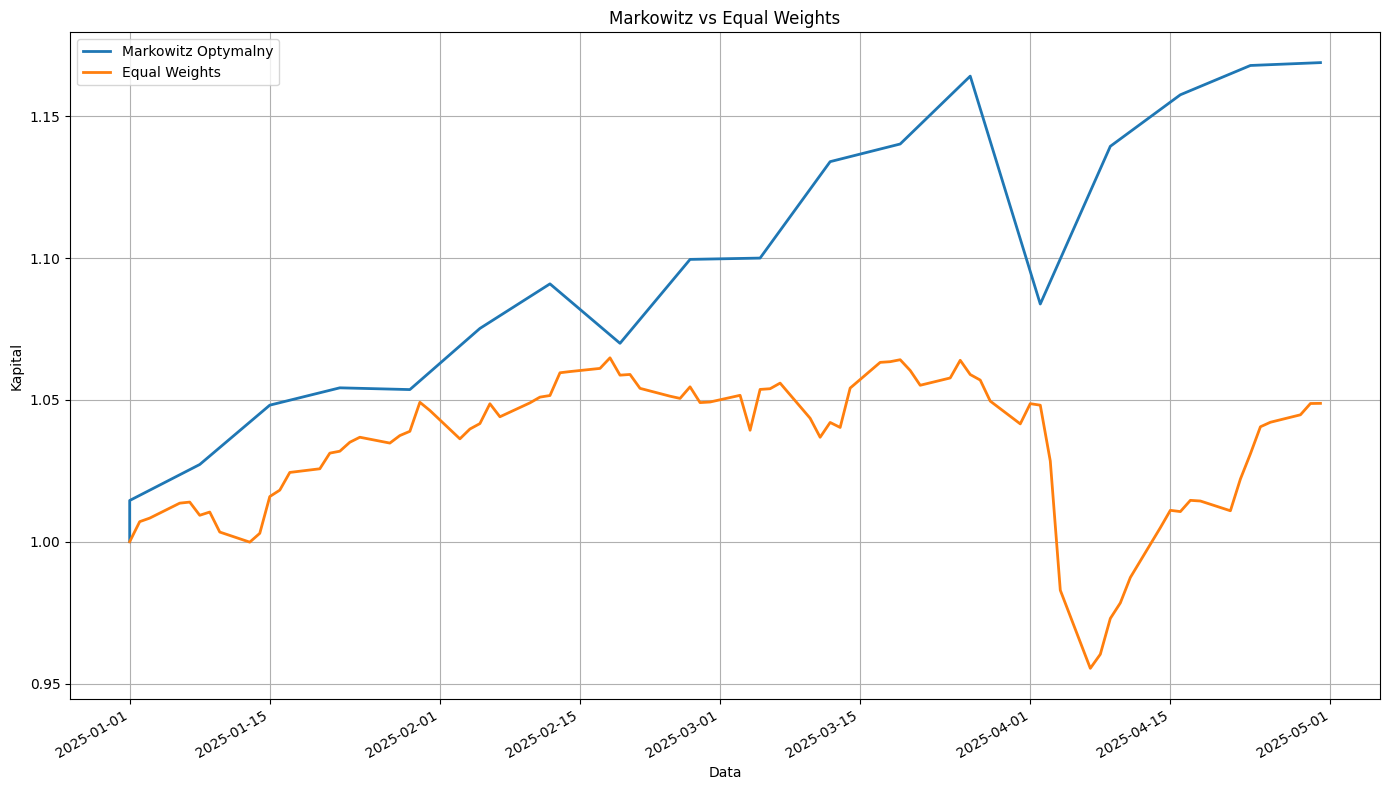

Statystyki Markowitz:
  Zwrot roczny (CAGR): 0.6144
  sredni zwrot: 2.2674
  Zmienność roczna: 0.3903
  Sharpe Ratio: 5.8088
  Max Drawdown: -0.0690
Statystyki Equal Weights:
  Zwrot roczny (CAGR): 0.1574
  sredni zwrot: 0.1503
  Zmienność roczna: 0.1346
  Sharpe Ratio: 1.1164
  Max Drawdown: -0.1028
koszty transakcyjne Markowitz: 0.0162
koszty transakcyjne Equal Weights: 0.0000


In [ ]:
#1.085
data_dir  = r".\mgr\kody\downloaded_data"
df_all = load_data(data_dir, sample_n=771)
pivoted = prepare_pivot(df_all)



#Zwrot roczny (CAGR)	sredni zwrot	Zmienność roczna	Sharpe Ratio	Max Drawdown	Okno (dni)	Target Return	Rebalans co (dni)	Koszt
#	0.614373	2.267380	0.390332	5.808847	-0.069009	60	0.0050	5	0.016243
#	0.289259	1.198232	0.277046	4.325025	-0.050308	30	0.0050	5	0.022610

# Markowitz
df_capital_mkv, total_cost_mkv = rolling_markowitz(
    pivoted_prices=pivoted,
    window_days=60,
    fee_rate=0.001,
    rebalance_period=5,
    target_return=0.005
)

# Equal Weights
df_capital_eq, total_cost_eq = rolling_equal(
    pivoted_prices=pivoted,
    rebalance_period=5,
    fee_rate=0.001
)

stats_mkv = calculate_portfolio_stats(df_capital_mkv)
stats_eq = calculate_portfolio_stats(df_capital_eq)


plt.figure(figsize=(14, 8))
df_capital_mkv.plot(label="Markowitz Optymalny", linewidth=2)
df_capital_eq.plot(label="Equal Weights", linewidth=2)
plt.title("Markowitz vs Equal Weights")
plt.xlabel("Data")
plt.ylabel("Kapital")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#
print("Statystyki Markowitz:")
for k, v in stats_mkv.items():
    print(f"  {k}: {v:.4f}")

print("Statystyki Equal Weights:")
for k, v in stats_eq.items():
    print(f"  {k}: {v:.4f}")

print(f"koszty transakcyjne Markowitz: {total_cost_mkv:.4f}")
print(f"koszty transakcyjne Equal Weights: {total_cost_eq:.4f}")


In [3]:
returns_test = pivoted.pct_change().dropna()
returns_2025 = returns_test[returns_test.index.year == 2025]
print("Średni dzienny zwrot w 2025:", returns_2025.mean().mean())
print("Liczba dni ze średnim zwrotem > 0:", (returns_2025.mean(axis=1) > 0).sum())


Średni dzienny zwrot w 2025: 0.002541764880010165
Liczba dni ze średnim zwrotem > 0: 55


In [13]:
results=pd.DataFrame(results)
results.sort_values(by="Sharpe Ratio", ascending=False, inplace=True)
results[results["Rebalans co (dni)"] == 5]

,Zwrot roczny (CAGR),sredni zwrot,Zmienność roczna,Sharpe Ratio,Max Drawdown,Okno (dni),Target Return,Rebalans co (dni),Koszt
8,0.614373,2.267380,0.390332,5.808847,-0.069009,60,0.0050,5,0.016243
0,0.289259,1.198232,0.277046,4.325025,-0.050308,30,0.0050,5,0.022610
24,0.135717,0.591090,0.144564,4.088775,-0.025777,120,0.0010,5,0.010505
26,0.081012,0.359538,0.091707,3.920506,-0.015227,120,0.0005,5,0.006973
16,0.108037,0.476141,0.127933,3.721788,-0.022183,90,0.0010,5,0.011120
12,1.075664,3.862835,1.128770,3.422163,-0.049131,60,0.0005,5,0.015910
18,0.063315,0.283682,0.086159,3.292530,-0.013031,90,0.0005,5,0.007735
22,0.397604,1.664926,0.525699,3.167074,-0.096585,120,0.0050,5,0.010224
28,0.037215,0.168770,0.066088,2.553724,-0.009975,120,0.0001,5,0.004823
20,0.026287,0.121253,0.078068,1.553170,-0.012944,90,0.0001,5,0.005656


In [ ]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm



def generate_statistical_stress_periods(pivoted_prices: pd.DataFrame,
                                        window: int = 20,
                                        volatility_quantile: float = 0.95,
                                        min_period_length: int = 5) -> dict:
    log_returns = np.log(pivoted_prices / pivoted_prices.shift(1)).dropna()
    portfolio_returns = log_returns.mean(axis=1)
    rolling_vol = portfolio_returns.rolling(window).std()
    vol_threshold = rolling_vol.quantile(volatility_quantile)
    high_vol_days = rolling_vol[rolling_vol > vol_threshold].index

    stress_periods = []
    if not high_vol_days.empty:
        current_start = high_vol_days[0]
        current_end = high_vol_days[0]
        for date in high_vol_days[1:]:
            if (date - current_end).days <= 3:
                current_end = date
            else:
                if (current_end - current_start).days + 1 >= min_period_length:
                    stress_periods.append((current_start, current_end))
                current_start = date
                current_end = date
        if (current_end - current_start).days + 1 >= min_period_length:
            stress_periods.append((current_start, current_end))

    return {
        f"StatStress_{i+1}": (start.strftime("%Y-%m-%d"), end.strftime("%Y-%m-%d"))
        for i, (start, end) in enumerate(stress_periods)
    }

def generate_stress_data(pivoted: pd.DataFrame, periods: dict) -> pd.DataFrame:
    stress_data_segments = []
    for label, (start, end) in periods.items():
        segment = pivoted.loc[start:end].pct_change().dropna()
        segment["SCENARIO"] = label
        stress_data_segments.append(segment)
    return pd.concat(stress_data_segments).dropna(axis=1)

def generate_bootstrap_stress_paths(returns_df: pd.DataFrame,
                                    path_length: int = 21,
                                    n_paths: int = 5,
                                    block_size: int = 5) -> list:
    returns_df = returns_df.drop(columns=["SCENARIO"], errors="ignore").dropna(axis=1)
    block_starts = np.arange(len(returns_df) - block_size + 1)
    paths = []
    for _ in range(n_paths):
        idx = np.random.choice(block_starts, size=(path_length // block_size + 1), replace=True)
        sampled_blocks = [returns_df.iloc[i:i + block_size] for i in idx]
        sampled_path = pd.concat(sampled_blocks).iloc[:path_length]
        paths.append(sampled_path.reset_index(drop=True))
    return paths


n_iterations = 100
path_length = 22
block_size = 5
output_dir = "rolling_results_markowitz/"
os.makedirs(output_dir, exist_ok=True)


statistical_stress_periods = generate_statistical_stress_periods(
    pivoted_prices=pivoted,
    window=5,
    volatility_quantile=0.5,
    min_period_length=5
)

stress_data_real = generate_stress_data(pivoted, statistical_stress_periods)
sample_columns = pivoted.columns
last_prices = pivoted.loc[pivoted.index < "2025-05-01"].iloc[-1]
historical_prices = pivoted.copy()

results_markowitz = []

for i in tqdm(range(n_iterations), desc="Rolling stress test iterations - Markowitz"):
    stress_paths = generate_bootstrap_stress_paths(
        stress_data_real[sample_columns],
        path_length=path_length,
        n_paths=1,
        block_size=block_size
    )
    stress_path = stress_paths[0]

    stress_prices = pd.DataFrame(
        data=np.cumprod(1 + stress_path.values, axis=0) * last_prices.values,
        columns=sample_columns,
        index=pd.date_range("2025-05-01", periods=path_length, freq="B")
    )

    stress_full = pd.concat([historical_prices, stress_prices])

    capital_series, _,_ = rolling_markowitz(
        pivoted_prices=stress_full,
        window_days=60,
        fee_rate=0.001,
        rebalance_period=5,
        target_return=0.001
    )

    capital_series.to_csv(f"{output_dir}/capital_iteration_{i+1}.csv")
    results_markowitz.append(capital_series)

capital_series_combined = pd.concat(results_markowitz, axis=1)
capital_series_combined.columns = [f"Iteration_{i+1}" for i in range(n_iterations)]
capital_series_combined.to_csv(f"{output_dir}/combined_capital.csv")


c:\Users\Basia\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)
Rolling stress test iterations - Markowitz: 100%|██████████| 100/100 [1:30:52<00:00, 54.53s/it]


<Axes: >

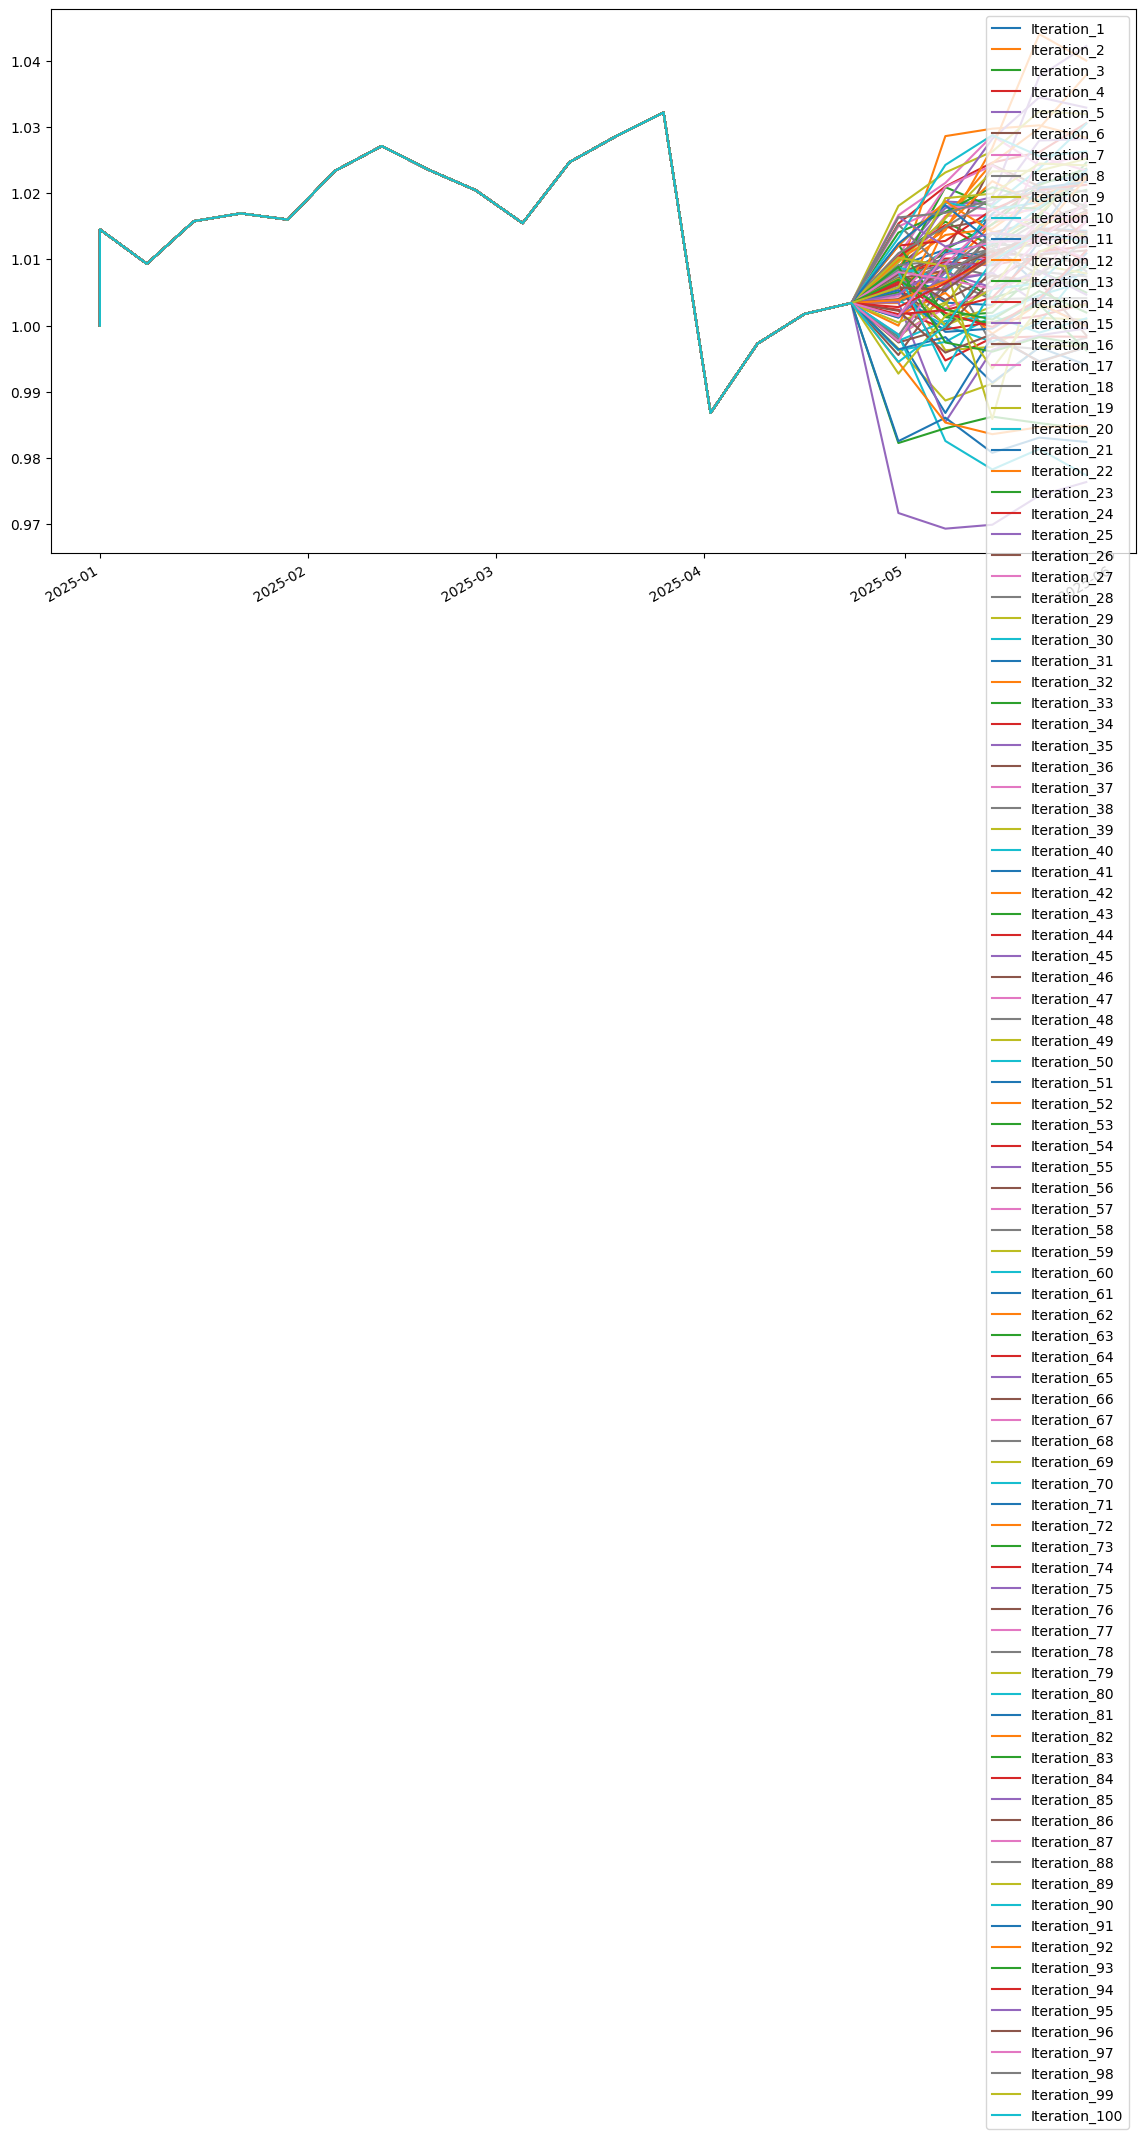

In [22]:
capital_series_combined.plot(figsize=(14, 8))